In [1]:
%pwd
%cd /content/drive/MyDrive/contest3/
%ls -l

/content/drive/MyDrive/contest3
total 188606
-rw------- 1 root root   479115 Nov 27 13:13 baseline-deeplabv3-crack-segmentation.ipynb
-rw------- 1 root root 72055804 Nov 23 00:03 copy-of-crack-segmentation-cnu.zip
-rw------- 1 root root   718488 Nov 28 03:27 crack_detection.ipynb
drwx------ 2 root root     4096 Nov 27 11:14 data/
-rw------- 1 root root 67708808 Nov 22 05:11 DeepCrack.zip
drwx------ 2 root root     4096 Nov 27 11:57 DeepSegmentor/
drwx------ 2 root root     4096 Nov 28 14:31 HrSegNet4CrackSegmentation/
-rw------- 1 root root   473883 Nov 29 03:16 HrSegNet.ipynb
drwx------ 2 root root     4096 Nov 27 11:25 kaggle_dataset/
drwx------ 2 root root     4096 Nov 27 13:28 model_checkpoint/
-rw------- 1 root root 51674219 Nov 28 03:19 results.csv
-rw------- 1 root root      331 Nov 27 10:28 slient_night_holy_night.txt


In [3]:
!git clone https://github.com/CHDyshli/HrSegNet4CrackSegmentation.git

Cloning into 'HrSegNet4CrackSegmentation'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 210 (delta 113), reused 132 (delta 66), pack-reused 0
Receiving objects: 100% (210/210), 14.57 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [4]:
!pip install paddlepaddle-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.5/542.5 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00


In [8]:
!pip install paddleseg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.3/424.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split

from glob import glob
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision
import random, gc

seed=42

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"current device : {device}")

current device : cuda


In [4]:
CFG = {
    'EPOCHS' : 30,
    'LEARNING_RATE' : 1e-4,
    'NUM_CLASSES' : 1,
    'BATCH_SIZE' : 4,
    'SEED' : 42,
    'IMAGE_SIZE' : 256,
    'PATH' : os.path.join('/content/drive/MyDrive/contest3/model_checkpoint/', 'segment_model.pth')
}

In [5]:
def init_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  np.random.seed(seed)

  random.seed(seed)

  gc.collect()
  torch.cuda.empty_cache()

init_seed(CFG['SEED'])

In [6]:
base_path = '/content/drive/MyDrive/contest3/kaggle_dataset/'
path_to_images = os.path.join(base_path, 'train_img')
path_to_masks = os.path.join(base_path, 'train_lab')

image_paths = sorted(glob(path_to_images + '/*.jpg'))
mask_paths = sorted(glob(path_to_masks + '/*.png'))

In [7]:
test_files = pd.read_csv(os.path.join('/content/drive/MyDrive/contest3/kaggle_dataset/', 'test_files.csv'))
test_files

,ID,label
0,11194.jpg,0
1,11270-2.jpg,0
2,11296-6.jpg,0
3,11231-9.jpg,0
4,11249-6.jpg,0
...,...,...
232,IMG_6542-7.jpg,0
233,11295.jpg,0
234,11169-2.jpg,0
235,11247-8.jpg,0


In [8]:
print("img file counts : ", len(image_paths))
print("mask file counts : ", len(mask_paths))

img file counts :  300
mask file counts :  300


In [9]:
print("test file counts : ", len(test_files))

test file counts :  237


In [10]:
train_df = pd.DataFrame({'ID' : image_paths, 'label' : mask_paths})
train_df.head(5)

,ID,label
0,/content/drive/MyDrive/contest3/kaggle_dataset...,/content/drive/MyDrive/contest3/kaggle_dataset...
1,/content/drive/MyDrive/contest3/kaggle_dataset...,/content/drive/MyDrive/contest3/kaggle_dataset...
2,/content/drive/MyDrive/contest3/kaggle_dataset...,/content/drive/MyDrive/contest3/kaggle_dataset...
3,/content/drive/MyDrive/contest3/kaggle_dataset...,/content/drive/MyDrive/contest3/kaggle_dataset...
4,/content/drive/MyDrive/contest3/kaggle_dataset...,/content/drive/MyDrive/contest3/kaggle_dataset...


In [11]:
test_files['ID'] = base_path + '/test_img/' + test_files['ID']
test_files.head(5)

,ID,label
0,/content/drive/MyDrive/contest3/kaggle_dataset...,0
1,/content/drive/MyDrive/contest3/kaggle_dataset...,0
2,/content/drive/MyDrive/contest3/kaggle_dataset...,0
3,/content/drive/MyDrive/contest3/kaggle_dataset...,0
4,/content/drive/MyDrive/contest3/kaggle_dataset...,0


In [12]:
train, valid = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=seed)

print(f"splited train size : {len(train)}, \
 validation size: {len(valid)}, test size : {len(test_files)}")


splited train size : 270,  validation size: 30, test size : 237


In [13]:
train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    T.ToTensor()
])

In [14]:
class CrackDataset(Dataset):
  def __init__(self, dataset, train_mode=True, transforms=train_transforms):
    self.dataset = dataset.reset_index(drop=True)
    self.transforms = transforms
    self.train_mode = train_mode

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset.loc[idx].squeeze()

    if self.train_mode:
      image_path = row['ID']
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image_tensor = self.transforms(image).float()

      mask_path = row['label']
      mask = cv2.imread(mask_path)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      mask = cv2.resize(mask, (CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']))

      _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
      mask_tensor = torch.as_tensor(mask[None], dtype=torch.float32)

      return image_tensor, mask_tensor

    else:
      image_path = row['ID']
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image_tensor = self.transforms(image).float()

      return image_tensor

  def collate_fn(self, batch):
    images, masks = tuple(zip(*batch))

    # pytorch None indexing specifies one dimension (not possible in python syntax..)
    images = [img[None] for img in images]
    masks = [msk[None] for msk in masks]

    images, masks = [torch.cat(i).to(device) for i in [images, masks]]
    return images, masks

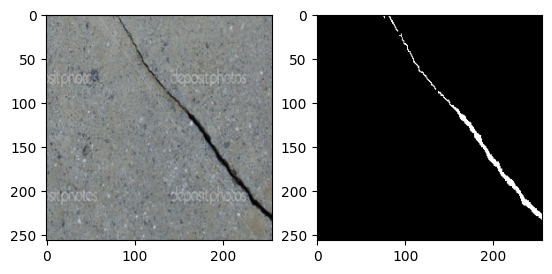

In [15]:
train_data = CrackDataset(train)

plt.subplot(121)
# channel, height, width -> height, width, channel (transpose(1, 2, 0))
# train[1][0] -> train image, train[1][1] -> train mask(label)
# train[idx] -> train image index
plt.imshow(train_data[15][0].cpu().detach().numpy().transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(train_data[15][1].cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')

In [16]:
@torch.no_grad()
def validate_test_image(model, dataset):
  idx = np.random.randint(len(dataset))
  dataset = dataset.reset_index(drop=True)
  row = dataset.loc[idx].squeeze()

  image = cv2.imread(row['ID'])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_tensor = train_transforms(image).unsqueeze(0).to(device)

  mask = cv2.imread(row['label'])
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.resize(mask, (CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']))
  _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

  model.eval()
  output = model(image_tensor)
  output = output[0].cpu().detach().numpy().transpose(1, 2, 0)

  plt.figure(figsize=(8, 4))
  plt.subplot(131)
  plt.title('Original image')
  plt.imshow(image)

  plt.subplot(132)
  plt.title('Original mask')
  plt.imshow(mask, cmap='gray')

  plt.subplot(133)
  plt.title('Predicted mask')
  plt.imshow(output, cmap='gray')


  plt.tight_layout()
  plt.show()
  plt.pause(0.001)


In [17]:
train_dataset = CrackDataset(train)
valid_dataset = CrackDataset(valid)
test_dataset = CrackDataset(test_files, train_mode=False)

train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True,
                              collate_fn = train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False,
                              collate_fn=valid_dataset.collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

In [18]:
import math
import torch.nn.functional as F

class HrSegNetB64(nn.Module):
    """
    Args:
        num_classes (int): The unique number of target classes.

        in_channels (int, optional): The channels of input image. Default: 3.

        base (int, optional): The base channel number of the model. Default: 48.
    """
    def __init__(self,
                 in_channels=3, # input channel
                 base=64, # base channel of the model,
                 num_classes=1, # number of classes
                 pretrained=None
                 ):
        super(HrSegNetB64, self).__init__()
        self.base = base
        self.num_classed = num_classes
        self.pretrained = pretrained
        # Stage 1 and 2 constitute the stem of the model, which is mainly used to extract low-level features.
        # Meanwhile, stage1 and 2 reduce the input image to 1/2 and 1/4 of the original size respectively
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=base // 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base // 2),
            nn.ReLU(),
        )
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=base // 2, out_channels=base, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU(),
        )

        self.seg1 = SegBlock(base=base, stage_index=1)
        self.seg2 = SegBlock(base=base, stage_index=2)
        self.seg3 = SegBlock(base=base, stage_index=3)

        self.aux_head1 = SegHead(inplanes=base, interplanes=base, outplanes=num_classes, aux_head=True)
        self.aux_head2 = SegHead(inplanes=base, interplanes=base, outplanes=num_classes, aux_head=True)
        self.head = SegHead(inplanes=base, interplanes=base, outplanes=num_classes)

        self.init_weight()


    def forward(self, x):
        logit_list = []
        h, w = x.shape[2], x.shape[3]
        # aux_head only used in training
        if self.training:
            stem1_out = self.stage1(x)
            stem2_out = self.stage2(stem1_out)
            hrseg1_out = self.seg1(stem2_out)
            hrseg2_out = self.seg2(hrseg1_out)
            hrseg3_out = self.seg3(hrseg2_out)
            last_out = self.head(hrseg3_out)
            seghead1_out = self.aux_head1(hrseg1_out)
            seghead2_out = self.aux_head2(hrseg2_out)
            logit_list = [last_out, seghead1_out, seghead2_out]
            logit_list = [F.interpolate(logit, size=(h, w), mode='bilinear', align_corners=True) for logit in logit_list]
            return (logit_list[0], logit_list[1], logit_list[2])
        else:
            stem1_out = self.stage1(x)
            stem2_out = self.stage2(stem1_out)
            hrseg1_out = self.seg1(stem2_out)
            hrseg2_out = self.seg2(hrseg1_out)
            hrseg3_out = self.seg3(hrseg2_out)
            last_out = self.head(hrseg3_out)
            logit_list = [last_out]
            logit_list = [F.interpolate(logit, size=(h, w), mode='bilinear', align_corners=True) for logit in logit_list]
            return logit_list[0]

    # we does not use pretrained model on other crack dataset
    def init_weight(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          torch.nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
          torch.nn.init.constant_(m.weight, 1)
          torch.nn.init.constant_(m.bias, 0)



class SegBlock(nn.Module):
    def __init__(self,
                 base=32,
                 stage_index=1):# stage_index=1,2,3.
        super(SegBlock, self).__init__()

        #  Convolutional layer for high-resolution paths with constant spatial resolution and constant channel
        self.h_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=base, out_channels=base, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU()
        )
        self.h_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=base, out_channels=base, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU()
        )
        self.h_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=base, out_channels=base, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU()
        )

        # sematic guidance path/low-resolution path
        if stage_index==1: #first stage, stride=2, spatial resolution/2, channel*2
            self.l_conv1 = nn.Sequential(
                nn.Conv2d(in_channels=base, out_channels=base*int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base*int(math.pow(2, stage_index))),
                nn.ReLU()
            )
        elif stage_index==2: #second stage
            self.l_conv1 = nn.Sequential(
                nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                nn.Conv2d(in_channels=base, out_channels=base*int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base*int(math.pow(2, stage_index))),
                nn.ReLU()
            )
        elif stage_index==3:
            self.l_conv1 = nn.Sequential(
                nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                nn.Conv2d(in_channels=base, out_channels=base*int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base*int(math.pow(2, stage_index))),
                nn.ReLU(),
                nn.Conv2d(in_channels=base*int(math.pow(2, stage_index)), out_channels=base*int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base*int(math.pow(2, stage_index))),
                nn.ReLU()
            )
        else:
            raise ValueError("stage_index must be 1, 2 or 3")
        self.l_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=base*int(math.pow(2, stage_index)), out_channels=base*int(math.pow(2, stage_index)), kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base*int(math.pow(2, stage_index))),
            nn.ReLU()
        )
        self.l_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=base*int(math.pow(2, stage_index)), out_channels=base*int(math.pow(2, stage_index)), kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base*int(math.pow(2, stage_index))),
            nn.ReLU()
        )

        self.l2h_conv1 = nn.Conv2d(in_channels=base*int(math.pow(2, stage_index)), out_channels=base, kernel_size=1, stride=1, padding=0)
        self.l2h_conv2 = nn.Conv2d(in_channels=base*int(math.pow(2, stage_index)), out_channels=base, kernel_size=1, stride=1, padding=0)
        self.l2h_conv3 = nn.Conv2d(in_channels=base*int(math.pow(2, stage_index)), out_channels=base, kernel_size=1, stride=1, padding=0)



    def forward(self, x):
        # out = []
        # out.append(self.h_conv3(self.h_conv2(self.h_conv1(x))))
        # out.append(self.l_conv3(self.l_conv2(self.l_conv1(x))))
        size = x.shape[2:]
        out_h1 = self.h_conv1(x) # high resolution path
        out_l1 = self.l_conv1(x) # low resolution path
        # print(out_l1.shape)
        out_l1_i = F.interpolate(out_l1, size=size, mode='bilinear', align_corners=True) # upsample
        out_hl1 = self.l2h_conv1(out_l1_i) + out_h1 # low to high

        out_h2 = self.h_conv2(out_hl1)
        out_l2 = self.l_conv2(out_l1)
        # print(out_l2.shape)
        out_l2_i = F.interpolate(out_l2, size=size, mode='bilinear', align_corners=True)
        out_hl2 = self.l2h_conv2(out_l2_i) + out_h2

        out_h3 = self.h_conv3(out_hl2)
        out_l3 = self.l_conv3(out_l2)
        # print(out_l3.shape)
        out_l3_i = F.interpolate(out_l3, size=size, mode='bilinear', align_corners=True)
        out_hl3 = self.l2h_conv3(out_l3_i) + out_h3
        return out_hl3

# seg head
class SegHead(nn.Module):
    def __init__(self, inplanes, interplanes, outplanes, aux_head=False):
        super(SegHead, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU()
        if aux_head:
            self.con_bn_relu = nn.Sequential(
                nn.Conv2d(in_channels=inplanes, out_channels=interplanes, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(interplanes),
                nn.ReLU(),
            )
        else:
            self.con_bn_relu = nn.Sequential(
                nn.ConvTranspose2d(in_channels=inplanes, out_channels=interplanes, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(interplanes),
                nn.ReLU(),
            )
        self.conv = nn.Conv2d(in_channels=interplanes, out_channels=outplanes, kernel_size=1, stride=1, padding=0)


    def forward(self, x):
        x = self.bn1(x)
        x = self.relu(x)
        x = self.con_bn_relu(x)
        out = self.conv(x)
        return out


def get_model():
  model = HrSegNetB64()
  return model.to(device)


model = get_model()

In [19]:
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0, path=CFG['PATH']):
    self.path = path
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = np.inf
    self.early_stop = False

  def __call__(self, val_loss, model=None):
    if self.best_loss - val_loss > self.min_delta:
      torch.save(model, self.path)
      print(f'Model saved to : {self.path}')
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
      if self.counter >= self.patience:
        print('INFO: Early stopping')
        self.early_stop = True


In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)
early=EarlyStopping()

In [21]:
def train_one_batch(batch, model, criterion, optimizer):
  images, masks = batch
  optimizer.zero_grad()
  output = model(images)
  loss1 = criterion(output[0], masks)
  loss2 = criterion(output[1], masks)
  loss3 = criterion(output[2], masks)
  loss = loss1+loss2+loss3
  loss.backward()
  optimizer.step()

  return loss.item()

@torch.no_grad()
def validate_one_batch(batch, model, criterion):
  images, masks = batch
  output = model(images)
  loss = criterion(output, masks)
  return loss.item()

def validate_one_batch(batch, model):
  images, masks = batch
  output = model(images)
  loss = criterion(output, masks)
  return loss.item()

Epoch 1/30


  0%|          | 0/67 [00:00<?, ?it/s]

Train loss: 5392.4674.


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 1713.0694.
--------------------------------------------------


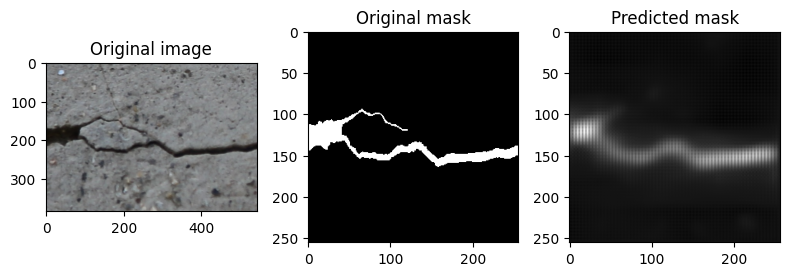

Val F1 Score: 0.0
Model saved to : /content/drive/MyDrive/contest3/model_checkpoint/segment_model.pth
Epoch 2/30


  0%|          | 0/67 [00:00<?, ?it/s]

Train loss: 5077.2587.


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 1621.0606.
--------------------------------------------------


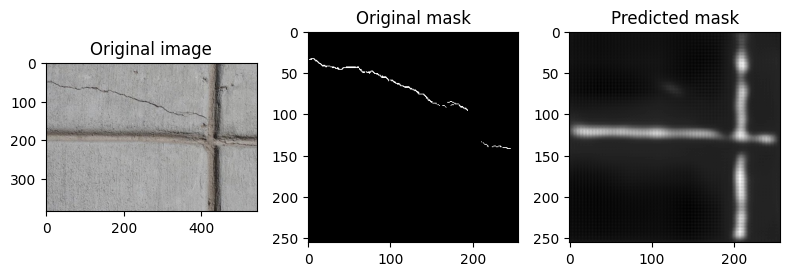

Val F1 Score: 0.0
Model saved to : /content/drive/MyDrive/contest3/model_checkpoint/segment_model.pth
Epoch 3/30


  0%|          | 0/67 [00:00<?, ?it/s]

Train loss: 4933.8144.


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 1664.7437.
--------------------------------------------------


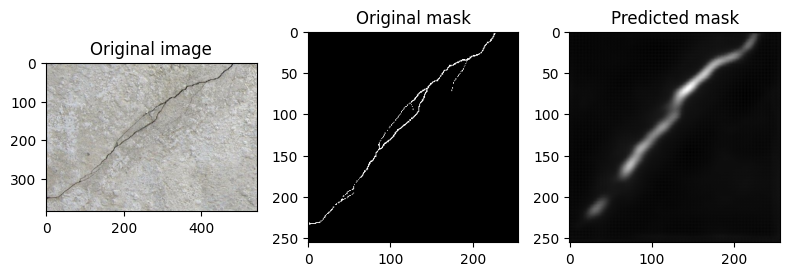

Val F1 Score: 0.0
INFO: Early stopping counter 1 of 5
Epoch 4/30


  0%|          | 0/67 [00:00<?, ?it/s]

In [ ]:
train_losses, valid_losses = [], []
from sklearn.metrics import f1_score

for epoch in range(CFG['EPOCHS']):

  print(f'Epoch {epoch+1}/{CFG["EPOCHS"]}')
  epoch_train_losses, epoch_valid_losses = [], []

  model.train()
  for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
    batch_train_loss = train_one_batch(batch, model, criterion, optimizer)
    epoch_train_losses.append(batch_train_loss)

  epoch_train_loss = np.array(epoch_train_losses).mean()
  train_losses.append(epoch_train_loss)

  print(f"Train loss: {epoch_train_loss:.4f}.")

  model.eval()
  y_true, y_pred = [], []

  for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
    images, masks = batch
    output = model(images)
    batch_valid_loss = criterion(output, masks)
    epoch_valid_losses.append(batch_valid_loss.item())

    y_true.append(masks.cpu().numpy())
    y_pred.append(output.cpu().detach().numpy())

  epoch_valid_loss = np.array(epoch_valid_losses).mean()
  valid_losses.append(epoch_valid_loss)
  print(f'Valid loss: {epoch_valid_loss:.4f}.')
  print('-'*50)

  y_true = np.concatenate(y_true, axis=0)
  y_pred = np.concatenate(y_pred, axis=0)
  y_pred = np.where(y_pred > 127, 255, 0)

  y_true = y_true.reshape(-1) / 255
  y_pred = y_pred.reshape(-1) / 255

  validate_test_image(model, valid)
  print('Val F1 Score:', f1_score(y_pred, y_true))


  scheduler.step(epoch_valid_loss)
  early(epoch_valid_loss, model =model)
  if early.early_stop:
    print(f"Validation loss did not improve for {early.patience} epochs. Training stopped.")
    model.load_state_dict(torch.load(CFG['PATH']))
    break


In [ ]:
y_pred = []
model = get_model()
model = torch.load(CFG['PATH'])
my_submission = pd.read_csv(os.path.join(base_path, 'test_files.csv'))

model.eval()
for path, images in tqdm(zip(my_submission['ID'], test_dataloader), total=len(test_dataloader)):
  output = model(images.to(device))['out'].cpu().detach().numpy()
  output = np.where(output.astype(np.float32) > 127, 255, 0) / 255
  output = output[0][0].reshape(-1, )
  img = list(map(int, output.tolist()))
  label = "".join(map(str, img))

  chunk_size = 8
  chunks = [label[i:i+chunk_size] for i in range(0, len(label), chunk_size)]

  for i in range(len(chunks)):
    y_pred.append([path+str(i), "2" + chunks[i]])


In [ ]:
submission = pd.DataFrame(y_pred, columns=['ID', 'label'])
submission['label'] = submission['label'].astype(int)
submission.to_csv('./results.csv', index=False)